## Mission


    Let us define the mission of our STOL aircraft

* Engine start, taxi
* Takeoff in less than 20 metre
* climb to 500 ft(typical altitude in competitions)
* cruise range = 10 km
* cruise speed will depend upon the airfoil selected
* approach and landing
* additionally for a go-around: climb, cruise = 10 km, approach and land.


Personally I want to make a plane that can be used both in competitions as well as for disaster relief and rural transportation as well! After all, as a responsible aerospace engineer, i cannot simply only focus on the competition aspects, i need to make good use of my inventions!

So for  competitions, it should be **takeoff within 20 metres** and for the disaster relief missions, it should takeoff within 200 metres. The key difference will be in the payload capacity. Due to additional payload for disaster relief, it will take more runway for takeoff but should be within 200 m

**But: first i shall focus only on one plane, the competition one.**

    Main Requirements:

* Takeoff distance (ground roll) ≤ 20 m
* Range ≥ 8 km
* Engine: Lycoming O320 engine

    
    Derived requirements:

> Landing gear configuration: Tricycle (no retraction system)

to provide a better view for the pilot while landing and to avoid awkward sitting positions as seen in conventional/taildragger landing gear

It doesn't make much sense to retract the landing gear as our primary aim is the minimize the takeoff distance and win the competition.

> Wing placement

High wing for stability as well as clear view of the ground for the pilot


> Number of engines

According to the code below, one engine seems fine. also, its a lot simple design with one engine. Just a tiny disadvantage would be that the vertical tail will be placed at some angle so that it opposes the torque generated by the engine








### **Instructions for Using the STOL Aircraft Design Code**

This notebook simulates and analyzes the design and performance of a Short Take-Off and Landing (STOL) aircraft. Follow the steps below to interact with the code:

1. **Initialization**:
   - Slide the `INITIALIZE` slider to `1` to activate the simulation.
   - You only need to do this once per session.

2. **Input Parameters**:
   ...


In [31]:
#necessary library to be installed before you run the code
!pip install ipywidgets --quiet
from IPython.display import display


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.8 MB/s eta 0:00:00


In [32]:
#THE MATHEMATICS WAS DONE BY ME AND TO SOME EXENT THE SYNTAX ALSO. I USED CHATGPT AND PERPLEXITY TO GIVE SLIDERS AND REFINED OTHER CODE
#ALL IN ALL, I LEARNT A LOT ABOUT STOL AIRCRAFT DESIGN
#REFINED THE CODE USING PERPLEXITY AI

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox

# ------------------------------------------------
# Constants and Setup
# ------------------------------------------------
GRAVITY = 9.81        # Acceleration due to gravity (m/s²)
AIR_GAS_CONSTANT = 287  # Gas constant for air (J/(kg·K))
AIR_VISCOSITY = 1.89e-5  # Air viscosity (Pa·s at standard conditions)
SPEED_OF_SOUND = 343.0  # Speed of sound at sea level (m/s)

# Material densities (kg/m³)
MATERIALS = {
    "Aluminium": 2700,
    "Fibreglass": 1900,
    "Carbon Fibre": 1600
}

def calculate_air_density(temperature_celsius, pressure_bar):
    """
    Calculate air density using the ideal gas law.

    Args:
        temperature_celsius: Air temperature in Celsius
        pressure_bar: Air pressure in bar

    Returns:
        Air density in kg/m³
    """
    temperature_kelvin = temperature_celsius + 273.15
    pressure_pascal = pressure_bar * 100000
    return pressure_pascal / (AIR_GAS_CONSTANT * temperature_kelvin)

def calculate_wing_geometry(wing_area, aspect_ratio):
    """
    Calculate basic wing geometry parameters.

    Args:
        wing_area: Wing area in m²
        aspect_ratio: Wing aspect ratio

    Returns:
        Dictionary with wingspan and chord length
    """
    wingspan = np.sqrt(aspect_ratio * wing_area)
    chord = wing_area / wingspan
    return {"wingspan": wingspan, "chord": chord}

def calculate_tail_geometry(wing_area, chord, wingspan, tail_distance, aspect_ratio):
    """
    Calculate horizontal and vertical tail dimensions based on standard volume coefficients.

    Args:
        wing_area: Wing area in m²
        chord: Wing chord in m
        wingspan: Wingspan in m
        tail_distance: Distance from wing to tail in m
        aspect_ratio: Wing aspect ratio

    Returns:
        Dictionary with tail dimensions
    """
    # Standard tail volume coefficients
    horizontal_tail_volume = 0.8  # Typical for STOL aircraft
    vertical_tail_volume = 0.03   # Typical for STOL aircraft

    # Horizontal tail parameters
    horizontal_tail_AR = 0.5 * aspect_ratio  # Typically lower than wing AR
    horizontal_tail_area = horizontal_tail_volume * wing_area * chord / tail_distance
    horizontal_tail_span = np.sqrt(horizontal_tail_AR * horizontal_tail_area)

    # Vertical tail parameters
    vertical_tail_AR = 1.41  # Typical value
    vertical_tail_area = vertical_tail_volume * wing_area * wingspan / tail_distance
    vertical_tail_span = np.sqrt(vertical_tail_AR * vertical_tail_area)

    return {
        "horizontal_tail_area": horizontal_tail_area,
        "horizontal_tail_span": horizontal_tail_span,
        "vertical_tail_area": vertical_tail_area,
        "vertical_tail_span": vertical_tail_span
    }

def calculate_component_masses(wing_area, wingspan, materials, material_selections):
    """
    Calculate the mass of the main aircraft components using simplified models.

    Args:
        wing_area: Wing area in m²
        wingspan: Wingspan in m
        materials: Dictionary of material densities
        material_selections: Dictionary with selected materials for components

    Returns:
        Dictionary with component masses
    """
    # Skin thickness (m) - simplified assumption
    skin_thickness = 1e-3

    # Material densities for each component
    wing_density = materials[material_selections["wing"]]
    fuselage_density = materials[material_selections["fuselage"]]
    horizontal_tail_density = materials[material_selections["horizontal_tail"]]
    vertical_tail_density = materials[material_selections["vertical_tail"]]

    # Wing mass (simplified as two skins with constant thickness)
    wing_mass = wing_area * 2 * skin_thickness * wing_density

    # Fuselage parameters (simplified as a cylinder)
    fuselage_width = 1.2  # Cross-sectional width (m)
    fuselage_length = 0.8 * wingspan  # Typical proportion

    # Fuselage mass (simplified as cylindrical skin)
    fuselage_surface_area = 4 * fuselage_width * fuselage_length  # Simplified calculation
    fuselage_mass = fuselage_surface_area * skin_thickness * fuselage_density

    # Tail masses (simplified as a percentage of wing area with same thickness)
    horizontal_tail_mass = 0.2 * wing_area * 2 * skin_thickness * horizontal_tail_density
    vertical_tail_mass = 0.15 * wing_area * 2 * skin_thickness * vertical_tail_density

    return {
        "wing": wing_mass,
        "fuselage": fuselage_mass,
        "horizontal_tail": horizontal_tail_mass,
        "vertical_tail": vertical_tail_mass
    }

def calculate_fuel_mass(mass, range_km, cruise_speed, ld_max):
    """
    Calculate the required fuel mass using the Breguet range equation.

    Args:
        mass: Aircraft mass in kg
        range_km: Mission range in km
        cruise_speed: Cruise speed in m/s
        ld_max: Maximum lift-to-drag ratio

    Returns:
        Required fuel mass in kg
    """
    # Efficiency factors for different flight phases (typical values)
    wf_takeoff = 0.97   # Weight fraction remaining after takeoff
    wf_climb = 0.985    # Weight fraction remaining after climb
    wf_landing = 0.995  # Weight fraction remaining after landing

    # Convert to imperial units for traditional Breguet calculations
    cruise_speed_fts = cruise_speed * 3.28084  # m/s to ft/s
    range_ft = range_km * 3280.84              # km to ft

    # Engine specific fuel consumption parameters
    prop_efficiency = 0.8  # Propeller efficiency
    c_bhp_cruise = 0.4 / 3600  # Specific fuel consumption (lb/bhp/hr converted to per second)
    c_cruise_s = c_bhp_cruise * cruise_speed_fts / (550 * prop_efficiency)

    # Calculate cruise weight fraction using Breguet range equation
    ld_cruise = ld_max  # Simplification: cruise at max L/D
    wf_cruise = np.exp(-c_cruise_s * range_ft / (ld_cruise * cruise_speed_fts))

    # Calculate mission weight fraction
    wf_mission = wf_takeoff * wf_climb * wf_cruise * wf_landing

    # Add reserve fuel (6%)
    wf_fuel = 1.06 * (1 - wf_mission)

    # Calculate fuel mass
    fuel_mass = mass * wf_fuel

    return fuel_mass

def simulate_takeoff_roll(mass, thrust, cl_max, cd, wing_area, air_density, mu_r, takeoff_speed):
    """
    Simulate the takeoff ground roll and calculate performance parameters.

    Args:
        mass: Aircraft mass in kg
        thrust: Static thrust in N
        cl_max: Maximum lift coefficient
        cd: Drag coefficient
        wing_area: Wing area in m²
        air_density: Air density in kg/m³
        mu_r: Rolling friction coefficient
        takeoff_speed: Takeoff speed in m/s

    Returns:
        Tuple of arrays containing simulation data
    """
    # Maximum speed at which thrust is available (typically 1.5-2x takeoff speed)
    v_max_thrust = 86  # m/s

    # Simulation parameters
    dt = 0.01  # Time step (s)
    t = 0      # Initial time
    v = 0      # Initial velocity
    s = 0      # Initial distance

    # Data storage arrays
    time_data = []
    speed_data = []
    distance_data = []
    drag_data = []
    lift_data = []
    power_data = []

    # Calculate lift coefficient required at takeoff
    cl_takeoff = 2 * mass * GRAVITY / (air_density * takeoff_speed**2 * wing_area)
    cl_takeoff = min(cl_takeoff, cl_max)  # Cannot exceed maximum lift coefficient

    # Simulate the ground roll until reaching takeoff speed
    while v < takeoff_speed:
        # Calculate thrust available at current speed (decreases with speed)
        current_thrust = thrust * (1 - v / v_max_thrust)
        current_thrust = max(current_thrust, 0)  # Ensure non-negative thrust

        # Calculate aerodynamic drag
        drag = 0.5 * air_density * v**2 * wing_area * cd

        # Calculate current lift
        lift = 0.5 * air_density * v**2 * wing_area * cl_takeoff

        # Calculate rolling friction (reduces as lift increases)
        weight_on_wheels = max(0, mass * GRAVITY - lift)
        friction_force = mu_r * weight_on_wheels

        # Net force and acceleration
        net_force = current_thrust - drag - friction_force
        acceleration = net_force / mass

        # Update velocity and position using Euler integration
        v += acceleration * dt
        s += v * dt
        t += dt

        # Store data for plotting
        time_data.append(t)
        speed_data.append(v)
        distance_data.append(s)
        drag_data.append(drag)
        lift_data.append(lift)
        power_data.append(current_thrust * v / 1000)  # Power in kW

    return (np.array(time_data), np.array(speed_data), np.array(distance_data),
            np.array(drag_data), np.array(lift_data), np.array(power_data))

def plot_takeoff_analysis(initialize=0, airpressure_bar=1, airtemp_celsius=35, S=10, AR=7.0,
                          num_engines=1, T0_per_engine=290, td=18, mu_r=0.02, clmax=3.5,
                          LD_max=14, v_cruise=45, range_km=120, tail_dist=3.5, Payload=20,
                          material_wing="Aluminium", material_fuselage="Aluminium",
                          material_tail_h="Aluminium", material_tail_v="Aluminium"):
    """
    Main function to analyze STOL aircraft takeoff performance.

    Args:
        initialize: Initialization flag (must be set to 1 to run)
        airpressure_bar: Air pressure in bar
        airtemp_celsius: Air temperature in Celsius
        S: Wing area in m²
        AR: Wing aspect ratio
        num_engines: Number of engines
        T0_per_engine: Thrust per engine in kg
        td: Target takeoff distance in m
        mu_r: Rolling friction coefficient
        clmax: Maximum lift coefficient
        LD_max: Maximum lift-to-drag ratio
        v_cruise: Cruise speed in m/s
        range_km: Mission range in km
        tail_dist: Distance from wing to tail in m
        Payload: Payload mass in kg
        material_wing: Wing material
        material_fuselage: Fuselage material
        material_tail_h: Horizontal tail material
        material_tail_v: Vertical tail material

    Returns:
        None (produces plots and prints analysis results)
    """
    # Precondition: Check initialize flag
    if initialize != 1:
        print("SLIDE the INITIALIZE SLIDER TO 1 to run the simulation.")
        print("You don't need to repeat this step after the first run.")
        print("Made by OM NUNASE, 23b0003")
        return

    # Calculate atmospheric conditions
    air_density = calculate_air_density(airtemp_celsius, airpressure_bar)

    # Convert thrust from kg to Newtons
    T0 = num_engines * T0_per_engine * GRAVITY

    # Create a range of potential aircraft masses
    mass_range = np.linspace(50, 1000, 1000)
    weight_range = mass_range * GRAVITY

    # Calculate stall and takeoff speeds for the mass range
    v_stall = np.sqrt((2 * weight_range) / (air_density * S * clmax))
    v_to = 1.1 * v_stall  # Takeoff speed = 1.1 * stall speed

    # Calculate velocity attained after the specified takeoff distance
    v_attained = np.sqrt(2 * ((T0 - mu_r * weight_range) / mass_range) * td)

    # Find intersection point (maximum allowable mass)
    idx = np.abs(v_to - v_attained).argmin()
    mass_intersect, speed_intersect = mass_range[idx], v_to[idx]

    # Calculate wing geometry
    wing_geometry = calculate_wing_geometry(S, AR)
    wingspan = wing_geometry["wingspan"]
    chord = wing_geometry["chord"]

    # Calculate tail geometry
    tail_geometry = calculate_tail_geometry(S, chord, wingspan, tail_dist, AR)

    # Standard component masses
    mass_pilot = 51        # kg
    mass_engine = 111      # kg per engine
    mass_controls = 40     # kg
    mass_landing_gear = 20 # kg
    mass_propeller = 9     # kg

    # Calculate structural masses
    material_selections = {
        "wing": material_wing,
        "fuselage": material_fuselage,
        "horizontal_tail": material_tail_h,
        "vertical_tail": material_tail_v
    }

    component_masses = calculate_component_masses(S, wingspan, MATERIALS, material_selections)

    # Calculate total empty mass
    total_empty_mass = (num_engines * mass_engine + mass_controls +
                        component_masses["wing"] + component_masses["fuselage"] +
                        component_masses["horizontal_tail"] + component_masses["vertical_tail"] +
                        mass_landing_gear + mass_propeller)

    # Calculate fuel mass
    fuel_mass = calculate_fuel_mass(mass_intersect, range_km, v_cruise, LD_max)

    # Calculate total takeoff mass
    total_mass = mass_pilot + fuel_mass + total_empty_mass + Payload

    # Calculate takeoff speed for the total mass
    total_weight = total_mass * GRAVITY
    v_stall_total = np.sqrt((2 * total_weight) / (air_density * S * clmax))
    v_takeoff_total = 1.1 * v_stall_total

    # Calculate cruise parameters
    lift_at_cruise = total_mass * GRAVITY
    CL_cruise_required = 2 * lift_at_cruise / (air_density * v_cruise**2 * S)

    # Estimate drag coefficient (simplified)
    CD0 = 0.03  # Zero-lift drag coefficient (typical value)

    # Simulate takeoff roll
    time_data, speed_data, distance_data, drag_data, lift_data, power_data = simulate_takeoff_roll(
        total_mass, T0, clmax, CD0, S, air_density, mu_r, v_takeoff_total
    )

    # Calculate Reynolds numbers
    Re_takeoff = air_density * v_takeoff_total * chord / AIR_VISCOSITY
    Re_cruise = air_density * v_cruise * chord / AIR_VISCOSITY

    # Plot takeoff analysis
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(mass_range, v_to, label=f"Required takeoff Speed (CLmax={clmax:.2f}, S = {S:.2f} $m^2$)", color='blue')
    ax.plot(mass_range, v_attained, '--', color='green', label="Velocity Attained")
    ax.scatter(mass_intersect, speed_intersect, color='red', label="Intersection Point")
    ax.axvline(mass_intersect, linestyle='--', color='gray', alpha=0.5)
    ax.axvline(total_mass, linestyle='--', color='red', alpha=0.7)
    ax.set(xlabel="Mass (kg)", ylabel="Speed (m/s)",
           title=f"Takeoff Analysis (S={S}m², AR={AR}, Engines={num_engines}, T0={num_engines * T0_per_engine:.1f}kg)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 700)
    ax.set_ylim(0, 30)
    plt.tight_layout()
    plt.show()

    # Print analysis results
    print(f"Air density (kg/m³):  {air_density:.3f}")
    print(f"Air pressure (bar):   {airpressure_bar:.3f}")

    if total_mass <= mass_intersect:
        print("✅ Good: Total mass is less than or equal to the allowable mass!")
    else:
        print("⚠️ Warning: Total mass exceeds the allowable mass.")

    print("\n--- 🛫 Performance Metrics ---")
    print(f"Intersection Mass (Max Allowed):  {mass_intersect:.1f} kg")
    print(f"Takeoff distance:                 {distance_data[-1]:.2f} m")
    print(f"Speed at Takeoff:                 {v_takeoff_total:.2f} m/s")
    print(f"Lift at Takeoff:                  {0.5 * air_density * clmax * S * v_takeoff_total**2:.1f} N")
    print(f"Required CL at takeoff:           {2 * total_weight / (air_density * v_takeoff_total**2 * S):.3f}")
    print(f"Takeoff Mach number:              {v_takeoff_total/SPEED_OF_SOUND:.3f}")
    print(f"Takeoff Reynolds number:          {Re_takeoff:.1e}")
    print(f"Required Lift at cruise:          {total_mass * GRAVITY:.1f} N")
    print(f"Required CL at cruise:            {CL_cruise_required:.3f}")
    print(f"Cruise Mach number:               {v_cruise/SPEED_OF_SOUND:.4f}")
    print(f"Reynolds number at cruise:        {Re_cruise:.1e}")

    print("\n--- 📐 Geometry ---")
    print(f"Wingspan:                    {wingspan:.4f} m")
    print(f"Chord Length:                {chord:.4f} m")
    print(f"Wing Aspect Ratio:           {AR:.4f}")
    print(f"Tail distance:               {tail_dist:.4f} m")
    print(f"Area of horizontal tail:     {tail_geometry['horizontal_tail_area']:.3f} m²")
    print(f"Horizontal tail span:        {tail_geometry['horizontal_tail_span']:.3f} m")
    print(f"Area of vertical tail:       {tail_geometry['vertical_tail_area']:.3f} m²")
    print(f"Vertical tail span:          {tail_geometry['vertical_tail_span']:.3f} m")

    print("\n--- Mass Breakdown ---")
    print(f"• Wing Mass:              {component_masses['wing']:.1f} kg")
    print(f"• Fuselage Mass:          {component_masses['fuselage']:.1f} kg")
    print(f"• Horizontal Tail Mass:   {component_masses['horizontal_tail']:.1f} kg")
    print(f"• Vertical Tail Mass:     {component_masses['vertical_tail']:.1f} kg")
    print(f"• Engine Mass ({num_engines}x):     {num_engines * mass_engine:.1f} kg")
    print(f"• Propeller Mass:         {mass_propeller:.1f} kg")
    print(f"• Controls Mass:          {mass_controls:.1f} kg")
    print(f"• Pilot Mass:             {mass_pilot:.1f} kg")
    print(f"• Payload Mass:           {Payload:.1f} kg")
    print(f"• Landing Gear Mass:      {mass_landing_gear:.1f} kg")
    print(f"• Fuel Mass:              {fuel_mass:.1f} kg")
    print(f"\n Empty Mass of aircraft:   {total_empty_mass:.1f} kg")
    print(f" Total Takeoff Mass:       {total_mass:.1f} kg")
    print(f" Allowable Mass:           {mass_intersect:.1f} kg")
    print(f" Margin for Mass:          {mass_intersect - total_mass:.2f} kg")
    print(f"\n Empty weight fraction:    {total_empty_mass / total_mass:.2f}")
    print(f" Thrust-to-weight ratio:   {T0 / (total_mass * GRAVITY):.2f}")

    # Create plots
    # 1. Distance vs Time plot
    plt.figure(figsize=(10, 4))
    plt.plot(time_data, distance_data, color='green')
    plt.xlabel("Time (s)")
    plt.ylabel("Distance (m)")
    plt.title("Distance vs Time (Ground Roll)")
    plt.grid(True)
    plt.xlim(0, max(time_data))
    plt.legend(["Distance"])
    plt.tight_layout()
    plt.show()

    # 2. Speed vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, speed_data, color='blue')
    plt.xlabel("Distance (m)")
    plt.ylabel("Speed (m/s)")
    plt.title("Speed vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Lift vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, lift_data, color='orange')
    plt.xlabel("Distance (m)")
    plt.ylabel("Lift (N)")
    plt.title("Lift vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Drag vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, drag_data, color='red')
    plt.xlabel("Distance (m)")
    plt.ylabel("Drag (N)")
    plt.title("Drag vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Power vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, power_data, color='green')
    plt.xlabel("Distance (m)")
    plt.ylabel("Power (kW)")
    plt.title("Power vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define interactive widget
output = interactive(plot_takeoff_analysis,
    initialize=widgets.FloatSlider(min=0, max=1, step=1, value=0, description="INITIALIZE"),
    airpressure_bar=widgets.FloatSlider(min=0.5, max=1, step=0.01, value=0.92, description="AirP(bar)"),
    airtemp_celsius=widgets.FloatSlider(min=-10, max=70, step=0.5, value=50, description="AirTemp(°C)"),
    S=widgets.FloatSlider(min=5, max=30, step=1, value=12, description="Wing Area (m²)"),
    AR=widgets.FloatSlider(min=4, max=15, step=0.5, value=7.0, description="Aspect Ratio"),
    num_engines=widgets.IntSlider(min=1, max=2, step=1, value=1, description="Engines"),
    T0_per_engine=widgets.FloatSlider(min=1000/GRAVITY, max=3000/GRAVITY, step=10/GRAVITY, value=283, description="Thrust/Engine (kg)"),
    td=widgets.FloatSlider(min=1, max=200, step=1, value=17, description="Approx. Takeoff Dist (m)", description_width='initial'),
    mu_r=widgets.FloatSlider(min=0.01, max=0.05, step=0.005, value=0.02, description="Rolling μ"),
    clmax=widgets.FloatSlider(min=0.5, max=4.0, step=0.01, value=3.1, description="CLmax(Fowler Flap)"),
    LD_max=widgets.FloatSlider(min=1, max=20, step=0.5, value=7, description="L/D Max"),
    v_cruise=widgets.FloatSlider(min=10, max=80, step=1, value=52, description="Cruise Speed (m/s)"),
    range_km=widgets.FloatSlider(min=10, max=1000, step=10, value=100, description="Range (km)"),
    tail_dist=widgets.FloatSlider(min=1, max=20, step=0.1, value=3.5, description="tail_dist(m)"),
    Payload=widgets.FloatSlider(min=0, max=40, step=0.5, value=10, description="Payload(kg)"),
    material_wing=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Wing Material"),
    material_fuselage=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Fuselage Mat."),
    material_tail_h=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Horiz Tail Mat."),
    material_tail_v=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Vert Tail Mat.")
)

# Layout
controls = VBox(output.children[:-1])  # Controls beside the graph
display(HBox([output.children[-1], controls]))  # Graph on top, controls on the side


Note that the above values are approximate but very reasonable. Its a first approximation.

After this, we shall design the plane in OpenVSP and see the results.



###  takeoff and cruise Cd0

In [37]:


import numpy as np
# all lengths in metre

pi = np.pi
rho = 1.225
visc_air = 1.89 * 10**-5  # air viscosity
# fuselage drag at 0 deg.

L_fuselage = 7.0
D = 1.337
Sref = 20 #wing area

L_nose = 2.106
L_body = 0.806
L_tail = 4.088

Swet_nose = 0.75*pi*D*L_nose
Swet_body = pi*D*L_body
Swet_tail = 0.72*pi*D*L_tail

v_cruise = 27
v_takeoff = 12.55


Re_takeoff = rho*v_takeoff*L_fuselage / visc_air
Re_cruise = rho*v_cruise*L_fuselage / visc_air

Cf_takeoff = 0.455 / (np.log10(Re_takeoff))**2.58 - 1700/Re_takeoff
Cd0_takeoff = (Cf_takeoff/Sref)*(Swet_nose + Swet_body + Swet_tail)
print(f"Takeoff Cd0 = {Cd0_takeoff}")

Cf_cruise = 0.455 / (np.log10(Re_cruise))**2.58 - 1700/Re_cruise
Cd0_cruise = (Cf_cruise/Sref)*(Swet_nose + Swet_body + Swet_tail)
print(f"Cruise Cd0 = {Cd0_cruise}")


Takeoff Cd0 = 0.0033505035177233216
Cruise Cd0 = 0.00309949037313344


### Force and Torque balance by trial and error

In [ ]:
#Force and Torque balance

# Constants
r_tail = 4.569           # m (fixed)
m_total = 374.4        # kg
g = 9.81               # m/s²

CL_tail = 0.251        # Fixed
S_wing = 20            # m²
S_htail = 3.591        # m²
v_cruise = 27          # m/s
rho = 1.225            # default sea-level air density

# Function to update plot and print outputs
def update(r_wing=1.0, CL_wing=0.5):
    L_wing = 0.5 * rho * v_cruise**2 * S_wing * CL_wing
    L_tail = 0.5 * rho * v_cruise**2 * S_htail * CL_tail
    net_force = L_wing - L_tail - m_total * g
    net_torque = L_wing * r_wing - L_tail * r_tail

    # Print values
    print(f"✈️ r_wing = {r_wing:.5f} m, CL_wing = {CL_wing:.5f}")
    print(f"🔸 Lift (Wing): {L_wing:.2f} N")
    print(f"🔸 Lift (Tail): {L_tail:.2f} N (fixed CL_tail = {CL_tail})")
    print(f"📏 Net Vertical Force: {net_force:.2f} N")
    print(f"🧭 Net Torque (about CG): {net_torque:.2f} Nm")

    # Bar chart visualisation
    labels = ['Wing Lift', 'Tail Lift', 'Weight']
    values = [L_wing, L_tail, m_total * g]
    colors = ['skyblue', 'lightcoral', 'gray']

    plt.figure(figsize=(6, 4))
    plt.bar(labels, values, color=colors)
    plt.title("Lift and Weight Comparison")
    plt.ylabel("Force (N)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.show()

# Define sliders
r_wing_slider = widgets.FloatSlider(value=1.0, min=0.0, max=3.0, step=0.01, description='r_wing (m)')
CL_wing_slider = widgets.FloatSlider(value=0.53, min=0.0, max=2.0, step=0.01, description='CL_wing')

# Create interactive widget
ui = widgets.VBox([r_wing_slider, CL_wing_slider])
out = widgets.interactive_output(update, {'r_wing': r_wing_slider, 'CL_wing': CL_wing_slider})

display(ui, out)


#CL = 0.384
#r_wing = 0.2412m

#Cl = 0.4385
# r= 0.264


#new
'''
#CL = 0.4564
# r = 0.4215
therefore wing should be inclined at +0.4 deg.
tail should be further inclined at -2, therefore totally -5 deg.  to provide -0.251 CL at

'''

'''
again new
CL = 0.4564
r = 0.45

Putting this in in openvsp and computing the CG, we find that the CG lies perfectly where we want to

'''


THEREFORE, I found out that mounting the wing at 1.9 degrees will give a CL of around 0.4564 and placing the tail at -5 degrees will provide a CL of around 0.251 at absolute angle of attack = 0 degrees and will cancel out the torque and net force

After this, in OPENVSP, i placed the components such that the CG of the plane lies close to the CG of the pilot, to make it invariant who pilots it.

wing cl vs alpha


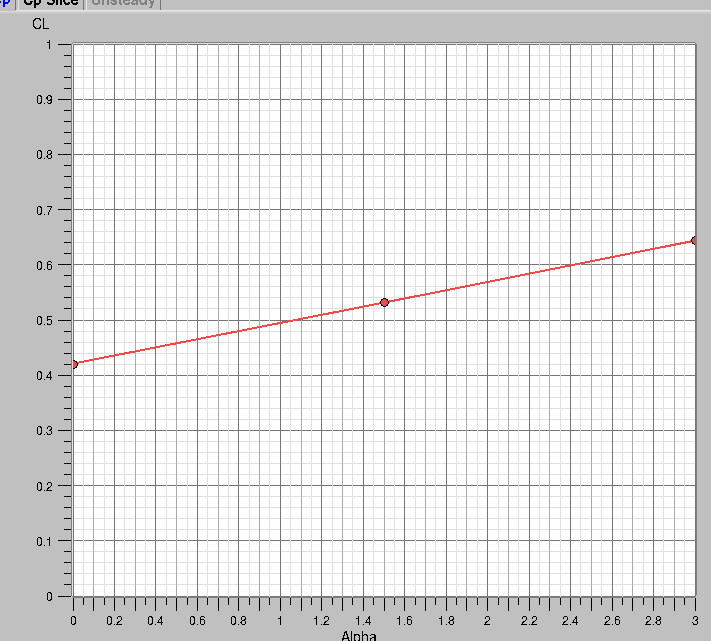

horizontal stabilser cl vs alpha

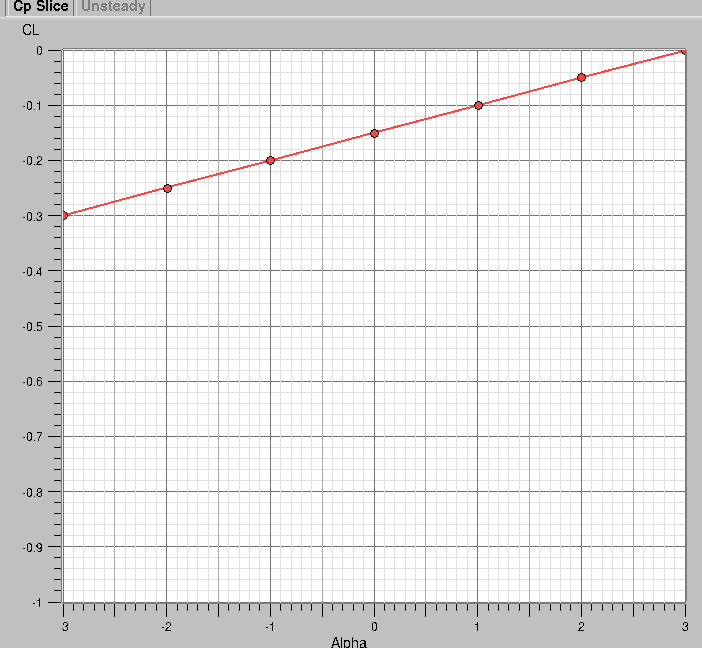

## BACKUP CODE:

In [ ]:
#THE MATHEMATICS WAS DONE BY ME AND TO SOME EXENT THE SYNTAX ALSO. I USED CHATGPT AND PERPLEXITY TO GIVE SLIDERS AND REFINED OTHER CODE
#ALL IN ALL, I LEARNT A LOT ABOUT STOL AIRCRAFT DESIGN
#REFINED THE CODE USING PERPLEXITY AI

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox

# ------------------------------------------------
# Constants and Setup
# ------------------------------------------------
GRAVITY = 9.81        # Acceleration due to gravity (m/s²)
AIR_GAS_CONSTANT = 287  # Gas constant for air (J/(kg·K))
AIR_VISCOSITY = 1.89e-5  # Air viscosity (Pa·s at standard conditions)
SPEED_OF_SOUND = 343.0  # Speed of sound at sea level (m/s)

# Material densities (kg/m³)
MATERIALS = {
    "Aluminium": 2700,
    "Fibreglass": 1900,
    "Carbon Fibre": 1600
}

def calculate_air_density(temperature_celsius, pressure_bar):
    """
    Calculate air density using the ideal gas law.

    Args:
        temperature_celsius: Air temperature in Celsius
        pressure_bar: Air pressure in bar

    Returns:
        Air density in kg/m³
    """
    temperature_kelvin = temperature_celsius + 273.15
    pressure_pascal = pressure_bar * 100000
    return pressure_pascal / (AIR_GAS_CONSTANT * temperature_kelvin)

def calculate_wing_geometry(wing_area, aspect_ratio):
    """
    Calculate basic wing geometry parameters.

    Args:
        wing_area: Wing area in m²
        aspect_ratio: Wing aspect ratio

    Returns:
        Dictionary with wingspan and chord length
    """
    wingspan = np.sqrt(aspect_ratio * wing_area)
    chord = wing_area / wingspan
    return {"wingspan": wingspan, "chord": chord}

def calculate_tail_geometry(wing_area, chord, wingspan, tail_distance, aspect_ratio):
    """
    Calculate horizontal and vertical tail dimensions based on standard volume coefficients.

    Args:
        wing_area: Wing area in m²
        chord: Wing chord in m
        wingspan: Wingspan in m
        tail_distance: Distance from wing to tail in m
        aspect_ratio: Wing aspect ratio

    Returns:
        Dictionary with tail dimensions
    """
    # Standard tail volume coefficients
    horizontal_tail_volume = 0.8  # Typical for STOL aircraft
    vertical_tail_volume = 0.03   # Typical for STOL aircraft

    # Horizontal tail parameters
    horizontal_tail_AR = 0.5 * aspect_ratio  # Typically lower than wing AR
    horizontal_tail_area = horizontal_tail_volume * wing_area * chord / tail_distance
    horizontal_tail_span = np.sqrt(horizontal_tail_AR * horizontal_tail_area)

    # Vertical tail parameters
    vertical_tail_AR = 1.41  # Typical value
    vertical_tail_area = vertical_tail_volume * wing_area * wingspan / tail_distance
    vertical_tail_span = np.sqrt(vertical_tail_AR * vertical_tail_area)

    return {
        "horizontal_tail_area": horizontal_tail_area,
        "horizontal_tail_span": horizontal_tail_span,
        "vertical_tail_area": vertical_tail_area,
        "vertical_tail_span": vertical_tail_span
    }

def calculate_component_masses(wing_area, wingspan, materials, material_selections):
    """
    Calculate the mass of the main aircraft components using simplified models.

    Args:
        wing_area: Wing area in m²
        wingspan: Wingspan in m
        materials: Dictionary of material densities
        material_selections: Dictionary with selected materials for components

    Returns:
        Dictionary with component masses
    """
    # Skin thickness (m) - simplified assumption
    skin_thickness = 1e-3

    # Material densities for each component
    wing_density = materials[material_selections["wing"]]
    fuselage_density = materials[material_selections["fuselage"]]
    horizontal_tail_density = materials[material_selections["horizontal_tail"]]
    vertical_tail_density = materials[material_selections["vertical_tail"]]

    # Wing mass (simplified as two skins with constant thickness)
    wing_mass = wing_area * 2 * skin_thickness * wing_density

    # Fuselage parameters (simplified as a cylinder)
    fuselage_width = 1.2  # Cross-sectional width (m)
    fuselage_length = 0.8 * wingspan  # Typical proportion

    # Fuselage mass (simplified as cylindrical skin)
    fuselage_surface_area = 4 * fuselage_width * fuselage_length  # Simplified calculation
    fuselage_mass = fuselage_surface_area * skin_thickness * fuselage_density

    # Tail masses (simplified as a percentage of wing area with same thickness)
    horizontal_tail_mass = 0.2 * wing_area * 2 * skin_thickness * horizontal_tail_density
    vertical_tail_mass = 0.15 * wing_area * 2 * skin_thickness * vertical_tail_density

    return {
        "wing": wing_mass,
        "fuselage": fuselage_mass,
        "horizontal_tail": horizontal_tail_mass,
        "vertical_tail": vertical_tail_mass
    }

def calculate_fuel_mass(mass, range_km, cruise_speed, ld_max):
    """
    Calculate the required fuel mass using the Breguet range equation.

    Args:
        mass: Aircraft mass in kg
        range_km: Mission range in km
        cruise_speed: Cruise speed in m/s
        ld_max: Maximum lift-to-drag ratio

    Returns:
        Required fuel mass in kg
    """
    # Efficiency factors for different flight phases (typical values)
    wf_takeoff = 0.97   # Weight fraction remaining after takeoff
    wf_climb = 0.985    # Weight fraction remaining after climb
    wf_landing = 0.995  # Weight fraction remaining after landing

    # Convert to imperial units for traditional Breguet calculations
    cruise_speed_fts = cruise_speed * 3.28084  # m/s to ft/s
    range_ft = range_km * 3280.84              # km to ft

    # Engine specific fuel consumption parameters
    prop_efficiency = 0.8  # Propeller efficiency
    c_bhp_cruise = 0.4 / 3600  # Specific fuel consumption (lb/bhp/hr converted to per second)
    c_cruise_s = c_bhp_cruise * cruise_speed_fts / (550 * prop_efficiency)

    # Calculate cruise weight fraction using Breguet range equation
    ld_cruise = ld_max  # Simplification: cruise at max L/D
    wf_cruise = np.exp(-c_cruise_s * range_ft / (ld_cruise * cruise_speed_fts))

    # Calculate mission weight fraction
    wf_mission = wf_takeoff * wf_climb * wf_cruise * wf_landing

    # Add reserve fuel (6%)
    wf_fuel = 1.06 * (1 - wf_mission)

    # Calculate fuel mass
    fuel_mass = mass * wf_fuel

    return fuel_mass

def simulate_takeoff_roll(mass, thrust, cl_max, cd, wing_area, air_density, mu_r, takeoff_speed):
    """
    Simulate the takeoff ground roll and calculate performance parameters.

    Args:
        mass: Aircraft mass in kg
        thrust: Static thrust in N
        cl_max: Maximum lift coefficient
        cd: Drag coefficient
        wing_area: Wing area in m²
        air_density: Air density in kg/m³
        mu_r: Rolling friction coefficient
        takeoff_speed: Takeoff speed in m/s

    Returns:
        Tuple of arrays containing simulation data
    """
    # Maximum speed at which thrust is available (typically 1.5-2x takeoff speed)
    v_max_thrust = 86  # m/s

    # Simulation parameters
    dt = 0.01  # Time step (s)
    t = 0      # Initial time
    v = 0      # Initial velocity
    s = 0      # Initial distance

    # Data storage arrays
    time_data = []
    speed_data = []
    distance_data = []
    drag_data = []
    lift_data = []
    power_data = []

    # Calculate lift coefficient required at takeoff
    cl_takeoff = 2 * mass * GRAVITY / (air_density * takeoff_speed**2 * wing_area)
    cl_takeoff = min(cl_takeoff, cl_max)  # Cannot exceed maximum lift coefficient

    # Simulate the ground roll until reaching takeoff speed
    while v < takeoff_speed:
        # Calculate thrust available at current speed (decreases with speed)
        current_thrust = thrust * (1 - v / v_max_thrust)
        current_thrust = max(current_thrust, 0)  # Ensure non-negative thrust

        # Calculate aerodynamic drag
        drag = 0.5 * air_density * v**2 * wing_area * cd

        # Calculate current lift
        lift = 0.5 * air_density * v**2 * wing_area * cl_takeoff

        # Calculate rolling friction (reduces as lift increases)
        weight_on_wheels = max(0, mass * GRAVITY - lift)
        friction_force = mu_r * weight_on_wheels

        # Net force and acceleration
        net_force = current_thrust - drag - friction_force
        acceleration = net_force / mass

        # Update velocity and position using Euler integration
        v += acceleration * dt
        s += v * dt
        t += dt

        # Store data for plotting
        time_data.append(t)
        speed_data.append(v)
        distance_data.append(s)
        drag_data.append(drag)
        lift_data.append(lift)
        power_data.append(current_thrust * v / 1000)  # Power in kW

    return (np.array(time_data), np.array(speed_data), np.array(distance_data),
            np.array(drag_data), np.array(lift_data), np.array(power_data))

def plot_takeoff_analysis(initialize=0, airpressure_bar=1, airtemp_celsius=35, S=10, AR=7.0,
                          num_engines=1, T0_per_engine=290, td=18, mu_r=0.02, clmax=3.5,
                          LD_max=14, v_cruise=45, range_km=120, tail_dist=3.5, Payload=20,
                          material_wing="Aluminium", material_fuselage="Aluminium",
                          material_tail_h="Aluminium", material_tail_v="Aluminium"):
    """
    Main function to analyze STOL aircraft takeoff performance.

    Args:
        initialize: Initialization flag (must be set to 1 to run)
        airpressure_bar: Air pressure in bar
        airtemp_celsius: Air temperature in Celsius
        S: Wing area in m²
        AR: Wing aspect ratio
        num_engines: Number of engines
        T0_per_engine: Thrust per engine in kg
        td: Target takeoff distance in m
        mu_r: Rolling friction coefficient
        clmax: Maximum lift coefficient
        LD_max: Maximum lift-to-drag ratio
        v_cruise: Cruise speed in m/s
        range_km: Mission range in km
        tail_dist: Distance from wing to tail in m
        Payload: Payload mass in kg
        material_wing: Wing material
        material_fuselage: Fuselage material
        material_tail_h: Horizontal tail material
        material_tail_v: Vertical tail material

    Returns:
        None (produces plots and prints analysis results)
    """
    # Precondition: Check initialize flag
    if initialize != 1:
        print("SLIDE the INITIALIZE SLIDER TO 1 to run the simulation.")
        print("You don't need to repeat this step after the first run.")
        print("Made by OM NUNASE, 23b0003")
        return

    # Calculate atmospheric conditions
    air_density = calculate_air_density(airtemp_celsius, airpressure_bar)

    # Convert thrust from kg to Newtons
    T0 = num_engines * T0_per_engine * GRAVITY

    # Create a range of potential aircraft masses
    mass_range = np.linspace(50, 1000, 1000)
    weight_range = mass_range * GRAVITY

    # Calculate stall and takeoff speeds for the mass range
    v_stall = np.sqrt((2 * weight_range) / (air_density * S * clmax))
    v_to = 1.1 * v_stall  # Takeoff speed = 1.1 * stall speed

    # Calculate velocity attained after the specified takeoff distance
    v_attained = np.sqrt(2 * ((T0 - mu_r * weight_range) / mass_range) * td)

    # Find intersection point (maximum allowable mass)
    idx = np.abs(v_to - v_attained).argmin()
    mass_intersect, speed_intersect = mass_range[idx], v_to[idx]

    # Calculate wing geometry
    wing_geometry = calculate_wing_geometry(S, AR)
    wingspan = wing_geometry["wingspan"]
    chord = wing_geometry["chord"]

    # Calculate tail geometry
    tail_geometry = calculate_tail_geometry(S, chord, wingspan, tail_dist, AR)

    # Standard component masses
    mass_pilot = 51        # kg
    mass_engine = 111      # kg per engine
    mass_controls = 40     # kg
    mass_landing_gear = 20 # kg
    mass_propeller = 9     # kg

    # Calculate structural masses
    material_selections = {
        "wing": material_wing,
        "fuselage": material_fuselage,
        "horizontal_tail": material_tail_h,
        "vertical_tail": material_tail_v
    }

    component_masses = calculate_component_masses(S, wingspan, MATERIALS, material_selections)

    # Calculate total empty mass
    total_empty_mass = (num_engines * mass_engine + mass_controls +
                        component_masses["wing"] + component_masses["fuselage"] +
                        component_masses["horizontal_tail"] + component_masses["vertical_tail"] +
                        mass_landing_gear + mass_propeller)

    # Calculate fuel mass
    fuel_mass = calculate_fuel_mass(mass_intersect, range_km, v_cruise, LD_max)

    # Calculate total takeoff mass
    total_mass = mass_pilot + fuel_mass + total_empty_mass + Payload

    # Calculate takeoff speed for the total mass
    total_weight = total_mass * GRAVITY
    v_stall_total = np.sqrt((2 * total_weight) / (air_density * S * clmax))
    v_takeoff_total = 1.1 * v_stall_total

    # Calculate cruise parameters
    lift_at_cruise = total_mass * GRAVITY
    CL_cruise_required = 2 * lift_at_cruise / (air_density * v_cruise**2 * S)

    # Estimate drag coefficient (simplified)
    CD0 = 0.03  # Zero-lift drag coefficient (typical value)

    # Simulate takeoff roll
    time_data, speed_data, distance_data, drag_data, lift_data, power_data = simulate_takeoff_roll(
        total_mass, T0, clmax, CD0, S, air_density, mu_r, v_takeoff_total
    )

    # Calculate Reynolds numbers
    Re_takeoff = air_density * v_takeoff_total * chord / AIR_VISCOSITY
    Re_cruise = air_density * v_cruise * chord / AIR_VISCOSITY

    # Plot takeoff analysis
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(mass_range, v_to, label=f"Required takeoff Speed (CLmax={clmax:.2f}, S = {S:.2f} $m^2$)", color='blue')
    ax.plot(mass_range, v_attained, '--', color='green', label="Velocity Attained")
    ax.scatter(mass_intersect, speed_intersect, color='red', label="Intersection Point")
    ax.axvline(mass_intersect, linestyle='--', color='gray', alpha=0.5)
    ax.axvline(total_mass, linestyle='--', color='red', alpha=0.7)
    ax.set(xlabel="Mass (kg)", ylabel="Speed (m/s)",
           title=f"Takeoff Analysis (S={S}m², AR={AR}, Engines={num_engines}, T0={num_engines * T0_per_engine:.1f}kg)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 700)
    ax.set_ylim(0, 30)
    plt.tight_layout()
    plt.show()

    # Print analysis results
    print(f"Air density (kg/m³):  {air_density:.3f}")
    print(f"Air pressure (bar):   {airpressure_bar:.3f}")

    if total_mass <= mass_intersect:
        print("✅ Good: Total mass is less than or equal to the allowable mass!")
    else:
        print("⚠️ Warning: Total mass exceeds the allowable mass.")

    print("\n--- 🛫 Performance Metrics ---")
    print(f"Intersection Mass (Max Allowed):  {mass_intersect:.1f} kg")
    print(f"Takeoff distance:                 {distance_data[-1]:.2f} m")
    print(f"Speed at Takeoff:                 {v_takeoff_total:.2f} m/s")
    print(f"Lift at Takeoff:                  {0.5 * air_density * clmax * S * v_takeoff_total**2:.1f} N")
    print(f"Required CL at takeoff:           {2 * total_weight / (air_density * v_takeoff_total**2 * S):.3f}")
    print(f"Takeoff Mach number:              {v_takeoff_total/SPEED_OF_SOUND:.3f}")
    print(f"Takeoff Reynolds number:          {Re_takeoff:.1e}")
    print(f"Required Lift at cruise:          {total_mass * GRAVITY:.1f} N")
    print(f"Required CL at cruise:            {CL_cruise_required:.3f}")
    print(f"Cruise Mach number:               {v_cruise/SPEED_OF_SOUND:.4f}")
    print(f"Reynolds number at cruise:        {Re_cruise:.1e}")

    print("\n--- 📐 Geometry ---")
    print(f"Wingspan:                    {wingspan:.4f} m")
    print(f"Chord Length:                {chord:.4f} m")
    print(f"Wing Aspect Ratio:           {AR:.4f}")
    print(f"Tail distance:               {tail_dist:.4f} m")
    print(f"Area of horizontal tail:     {tail_geometry['horizontal_tail_area']:.3f} m²")
    print(f"Horizontal tail span:        {tail_geometry['horizontal_tail_span']:.3f} m")
    print(f"Area of vertical tail:       {tail_geometry['vertical_tail_area']:.3f} m²")
    print(f"Vertical tail span:          {tail_geometry['vertical_tail_span']:.3f} m")

    print("\n--- Mass Breakdown ---")
    print(f"• Wing Mass:              {component_masses['wing']:.1f} kg")
    print(f"• Fuselage Mass:          {component_masses['fuselage']:.1f} kg")
    print(f"• Horizontal Tail Mass:   {component_masses['horizontal_tail']:.1f} kg")
    print(f"• Vertical Tail Mass:     {component_masses['vertical_tail']:.1f} kg")
    print(f"• Engine Mass ({num_engines}x):     {num_engines * mass_engine:.1f} kg")
    print(f"• Propeller Mass:         {mass_propeller:.1f} kg")
    print(f"• Controls Mass:          {mass_controls:.1f} kg")
    print(f"• Pilot Mass:             {mass_pilot:.1f} kg")
    print(f"• Payload Mass:           {Payload:.1f} kg")
    print(f"• Landing Gear Mass:      {mass_landing_gear:.1f} kg")
    print(f"• Fuel Mass:              {fuel_mass:.1f} kg")
    print(f"\n Empty Mass of aircraft:   {total_empty_mass:.1f} kg")
    print(f" Total Takeoff Mass:       {total_mass:.1f} kg")
    print(f" Allowable Mass:           {mass_intersect:.1f} kg")
    print(f" Margin for Mass:          {mass_intersect - total_mass:.2f} kg")
    print(f"\n Empty weight fraction:    {total_empty_mass / total_mass:.2f}")
    print(f" Thrust-to-weight ratio:   {T0 / (total_mass * GRAVITY):.2f}")

    # Create plots
    # 1. Distance vs Time plot
    plt.figure(figsize=(10, 4))
    plt.plot(time_data, distance_data, color='green')
    plt.xlabel("Time (s)")
    plt.ylabel("Distance (m)")
    plt.title("Distance vs Time (Ground Roll)")
    plt.grid(True)
    plt.xlim(0, max(time_data))
    plt.legend(["Distance"])
    plt.tight_layout()
    plt.show()

    # 2. Speed vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, speed_data, color='blue')
    plt.xlabel("Distance (m)")
    plt.ylabel("Speed (m/s)")
    plt.title("Speed vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Lift vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, lift_data, color='orange')
    plt.xlabel("Distance (m)")
    plt.ylabel("Lift (N)")
    plt.title("Lift vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Drag vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, drag_data, color='red')
    plt.xlabel("Distance (m)")
    plt.ylabel("Drag (N)")
    plt.title("Drag vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 5. Power vs Distance plot
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, power_data, color='green')
    plt.xlabel("Distance (m)")
    plt.ylabel("Power (kW)")
    plt.title("Power vs Distance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Define interactive widget
output = interactive(plot_takeoff_analysis,
    initialize=widgets.FloatSlider(min=0, max=1, step=1, value=0, description="INITIALIZE"),
    airpressure_bar=widgets.FloatSlider(min=0.5, max=1, step=0.01, value=0.92, description="AirP(bar)"),
    airtemp_celsius=widgets.FloatSlider(min=-10, max=70, step=0.5, value=50, description="AirTemp(°C)"),
    S=widgets.FloatSlider(min=5, max=30, step=1, value=12, description="Wing Area (m²)"),
    AR=widgets.FloatSlider(min=4, max=15, step=0.5, value=7.0, description="Aspect Ratio"),
    num_engines=widgets.IntSlider(min=1, max=2, step=1, value=1, description="Engines"),
    T0_per_engine=widgets.FloatSlider(min=1000/GRAVITY, max=3000/GRAVITY, step=10/GRAVITY, value=283, description="Thrust/Engine (kg)"),
    td=widgets.FloatSlider(min=1, max=200, step=1, value=17, description="Approx. Takeoff Dist (m)", description_width='initial'),
    mu_r=widgets.FloatSlider(min=0.01, max=0.05, step=0.005, value=0.02, description="Rolling μ"),
    clmax=widgets.FloatSlider(min=0.5, max=4.0, step=0.01, value=3.1, description="CLmax(Fowler Flap)"),
    LD_max=widgets.FloatSlider(min=1, max=20, step=0.5, value=7, description="L/D Max"),
    v_cruise=widgets.FloatSlider(min=10, max=80, step=1, value=52, description="Cruise Speed (m/s)"),
    range_km=widgets.FloatSlider(min=10, max=1000, step=10, value=100, description="Range (km)"),
    tail_dist=widgets.FloatSlider(min=1, max=20, step=0.1, value=3.5, description="tail_dist(m)"),
    Payload=widgets.FloatSlider(min=0, max=40, step=0.5, value=10, description="Payload(kg)"),
    material_wing=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Wing Material"),
    material_fuselage=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Fuselage Mat."),
    material_tail_h=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Horiz Tail Mat."),
    material_tail_v=widgets.Dropdown(options=MATERIALS.keys(), value="Carbon Fibre", description="Vert Tail Mat.")
)

# Layout
controls = VBox(output.children[:-1])  # Controls beside the graph
display(HBox([output.children[-1], controls]))  # Graph on top, controls on the side


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, HBox, VBox

print("SLIDE the INITIALIZE SLIDER TO 1. You don't need to repeat this step again")
print("Do note that the aircaft doesn't go above 500m from ground and so the air pressure and temperature values for takeoff and cruise are taken to be the same, so is the viscosity")
print("Made by OM NUNASE, 23b0003")

# Constants
g = 9.81  # m/s² acceleration due to gravity
rho = 1.225  # kg/m³ (sea level standard)
pi = np.pi
visc_air = 1.89 * 10**-5  # air viscosity
R = 287                   #gas constant for air

# Material densities (kg/m³)
materials = {
    "Aluminium": 2700,
    "Fibreglass": 1900,
    "Carbon Fibre": 1600
}

def plot_takeoff_analysis(initialize=0, airpressure_bar=1, airtemp_celsius=35, S=10, AR=7.0, num_engines=1, T0_per_engine=2000/g, td=18,
                          mu_r=0.02, clmax=3.5, LD_max=14, v_cruise=45, range_km=120, tail_dist=3.5, Payload=20,
                          material_wing="Aluminium", material_fuselage="Aluminium",
                          material_tail_h="Aluminium", material_tail_v="Aluminium"):
    g = 9.81
    # Initialize
    T = airtemp_celsius + 273.15
    P = airpressure_bar * 100000
    R = 287                       # gas constant for Air
    rho = P / (R * T)             # air density

    visc_air = 1.89 * 10**-5  # air viscosity

    T0 = num_engines * T0_per_engine * g  # Convert thrust to Newtons
    m = np.linspace(50, 1000, 1000)
    W = m * g
    v_stall = np.sqrt((2 * W) / (rho * S * clmax))
    v_to = 1.1 * v_stall
    v_attained = np.sqrt(2 * ((T0 - mu_r * W) / m) * td)  # Includes rolling resistance

    # Find intersection
    idx = np.abs(v_to - v_attained).argmin()
    mass_intersect, speed_intersect = m[idx], v_to[idx]

    # Create figure for takeoff analysis plot
    fig, ax = plt.subplots(figsize=(7, 4))

    # Geometry
    wingspan = np.sqrt(AR * S)
    chord = S / wingspan

    # Mass Estimates
    m_pilot, m_engine, m_controls, m_payload  = 51, 111, 40, Payload
    m_landinggear = 20
    t = 1e-3  # Skin thickness (m)

    # Material densities
    rho_wing = materials[material_wing]
    rho_fuselage = materials[material_fuselage]
    rho_tail_h = materials[material_tail_h]
    rho_tail_v = materials[material_tail_v]

       #tail calcualtions

    C = chord #chord of wing
    S = S   #area of main wing
    Vh = 0.8
    Df = 1  #max fuselage diameter
    #l_opt = np.sqrt(4*C*S*Vh/(pi*Df))
    l_opt = tail_dist
    print(f"optimum tail distance: {l_opt}")

    #horizontal tail
    Vh = 0.8
    AR_h = (2/3)* AR
    lh = tail_dist
    S_h = Vh * S * C/ lh
    print(f"Area of horizontal tail : {S_h} m2")

    #vertical tail
    Vv = 0.03
    AR_v = 1.41
    Taper_ratio_v = 0.5 #lambda_v taper ratio

    lv = tail_dist
    S_v = Vv * S * wingspan/ l_opt
    print(f"Area of vertical tail : {S_v} m2")

    b_v = np.sqrt(AR_v * S_v)
    print(f"Vertical tail span: {b_v}")

    mean_tail_chord = b_v / AR_v
    print(f"")



    # Component masses
    mass_wing_skin = S * 2 * t * rho_wing
    a, l = 1.2, 0.8 * wingspan
    mass_fuselage = (4 * a * l * t) * rho_fuselage
    mass_horizontal_tail = 0.2 * S * 2 * t * rho_tail_h
    mass_vertical_tail = 0.15 * S * 2 * t * rho_tail_v

    m_total_empty = num_engines * m_engine + m_controls + mass_wing_skin + mass_fuselage + mass_horizontal_tail + mass_vertical_tail + m_landinggear

    # Fuel Calculation
    wf_takeoff, wf_climb, wf_landing, n_prop = 0.97, 0.985, 0.995, 0.85
    LD_cruise = LD_max
    v_cruise_fts = v_cruise * 3.28084
    n_p = 0.8
    c_bhp_cruise = 0.4 / 3600
    c_cruise_s = c_bhp_cruise * v_cruise_fts / (550 * n_p)
    range_ft = range_km * 3280.84
    wf_cruise = np.exp(-c_cruise_s * range_ft / (LD_cruise * v_cruise_fts))

    wf_mission = wf_takeoff * wf_climb * wf_cruise * wf_landing
    wf_fuel = 1.06 * (1 - wf_mission)

    m_fuel = mass_intersect * wf_fuel
    m_total = m_pilot + m_fuel + m_total_empty + m_payload

    # Compute attained velocity for m_total
    W_total = m_total * g
    v_attained_total = np.sqrt(2 * ((T0 - mu_r * W_total) / m_total) * td)

    # Lift at cruise
    Lift_at_cruise = m_total * g
    CL_cruise_required = 2 * Lift_at_cruise / (rho * v_cruise**2 * S)
    CL_takeoff_required = 2 * Lift_at_cruise / (rho * v_attained_total**2 * S)

    # Plot takeoff analysis
    ax.plot(m, v_to, label=f"Required takeoff Speed (CLmax={clmax:.2f}, S = {S:.2f} $m^2$)", color='blue')
    ax.plot(m, v_attained, '--', color='green', label="Velocity Attained")
    ax.scatter(mass_intersect, speed_intersect, color='red', label="Intersection Point")
    ax.axvline(mass_intersect, linestyle='--', color='gray', alpha=0.5)
    ax.axvline(m_total, linestyle='--', color='red', alpha=0.7)
    ax.set(xlabel="Mass (kg)", ylabel="Speed (m/s)",
           title=f"Takeoff Analysis (S={S}m², AR={AR}, Engines={num_engines}, T0={num_engines * T0_per_engine:.1f}kg)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlim(0, 700)
    ax.set_ylim(0, 30)

    # Display the graph
    plt.tight_layout()

    # Ground roll performance simulation (speed vs time, distance vs time)
    g = 9.81
    T_static = T0_per_engine * num_engines * g
    V_max_thrust = 86
    mass = m_total
    rho = rho
    S = S
    C_D = 0.03
    V_takeoff = v_attained_total
    dt = 0.01
    t = 0
    v = 0
    s = 0
    time_data = []
    speed_data = []
    distance_data = []

    lift_data = []
    drag_data = []
    power_data = []

    while v < V_takeoff:
        T = T_static * (1 - v / V_max_thrust)
        T = max(T, 0)
        D = 0.5 * rho * v**2 * S * C_D
        F_rolling = mu_r * mass * g
        F_net = T - D - F_rolling
        a = F_net / mass
        v += a * dt
        s += v * dt
        t += dt

        # Append data
        time_data.append(t)
        speed_data.append(v)
        distance_data.append(s)
        drag_data.append(D)
        lift_data.append(0.5 * rho * v**2 * S * clmax)
        power_data.append(T * v / 1000)  # in kilowatts


    # Plot ground roll performance
    fig, ax = plt.subplots(figsize=(4, 4))

    # plt.subplot(1, 2, 1)
    # plt.plot(time_data, speed_data, label='Speed (m/s)', color='blue')
    # plt.axhline(V_takeoff, color='red', linestyle='--', label='Takeoff Speed')
    # plt.xlabel("Time (s)")
    # plt.ylabel("Speed (m/s)")
    # plt.title("Speed vs Time")
    # plt.grid(True)
    # plt.xlim(0, 3)
    # plt.ylim(0, 20)
    # plt.legend()

    #plt.subplot(1, , 2)
    plt.plot(time_data, distance_data, label='Distance (m)', color='green')
    plt.xlabel("Time (s)")
    plt.ylabel("Distance (m)")
    plt.title("Distance vs Time (Ground Roll)")
    plt.grid(True)
    plt.xlim(0, 5)
    plt.ylim(0, 25)
    plt.legend()

    plt.tight_layout()
    plt.show()

        # Plot Speed vs Distance
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, speed_data, color='blue')
    plt.xlabel("Distance (m)")
    plt.ylabel("Speed (m/s)")
    plt.title("Speed vs Distance")
    plt.grid(True)
    plt.show()

    # Plot Lift vs Distance
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, lift_data, color='orange')
    plt.xlabel("Distance (m)")
    plt.ylabel("Lift (N)")
    plt.title("Lift vs Distance")
    plt.grid(True)
    plt.show()

    # Plot Drag vs Distance
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, drag_data, color='red')
    plt.xlabel("Distance (m)")
    plt.ylabel("Drag (N)")
    plt.title("Drag vs Distance")
    plt.grid(True)
    plt.show()

    # Plot Power vs Distance
    plt.figure(figsize=(10, 4))
    plt.plot(distance_data, power_data, color='green')
    plt.xlabel("Distance (m)")
    plt.ylabel("Power (kW)")
    plt.title("Power vs Distance")
    plt.grid(True)
    plt.show()


    print() #space between graph and values for cleanliness

    Re_takeoff = rho * v_attained_total * chord / visc_air
    Re_cruise = rho * v_cruise * chord / visc_air

    print(f"Takeoff Mach number: {v_attained_total/343}")
    print(f"Takeoff Reynolds number: {Re_takeoff}")

    print(f"air density (kg/m3): {rho}")
    print(f"air pressure (bar): {airpressure_bar}")

    if m_total <= mass_intersect:
        print("✅ Good: Total mass is less than or equal to the allowable mass!")
    else:
        print("⚠️ Warning: Total mass exceeds the allowable mass.")

    print("\n--- 🛫 Performance Metrics ---")
    print(f"Intersection Mass (Max Allowed): {mass_intersect:.1f} kg")
    print(f"Speed at Takeoff: {speed_intersect:.2f} m/s")
    print(f"Lift at Takeoff: {0.5 * rho * clmax * S * speed_intersect**2:.1f} N")
    print(f"Required Lift at cruise: {m_total * g:.1f} N")
    print(f"Required CL at cruise: {CL_cruise_required}")
    print(f"Required CL at takeoff: {CL_takeoff_required}")



    print("\n--- 📐 Geometry ---")
    print(f"Wingspan: {wingspan:.4f} m")
    print(f"Chord Length: {chord:.4f} m")
    print(f"Aspect Ratio: {AR:.4f}")

    print("\n--- Mass Breakdown ---")
    print(f"• Wing Skin Mass:         {mass_wing_skin:.1f} kg")
    print(f"• Fuselage Mass:         {mass_fuselage:.1f} kg")
    print(f"• Horizontal Tail Mass:  {mass_horizontal_tail:.1f} kg")
    print(f"• Vertical Tail Mass:    {mass_vertical_tail:.1f} kg")
    print(f"• Engine Mass ({num_engines}x):     {num_engines * m_engine:.1f} kg")
    print(f"• Controls Mass:         {m_controls:.1f} kg")
    print(f"• Pilot Mass:            {m_pilot:.1f} kg")
    print(f"• Payload Mass:          {m_payload:.1f} kg")
    print(f"• Landing Gear Mass:     {m_landinggear:.1f} kg")

    print(f"\n Empty Mass (Excl. Fuel): {m_total_empty + m_pilot:.1f} kg")
    print(f" Fuel Mass:                {m_fuel:.1f} kg")
    print(f" Total Takeoff Mass:       {m_total:.1f} kg")
    print(f" Allowable Mass:           {mass_intersect:.1f} kg")
    print(f" Margin for Mass:   {mass_intersect - m_total}")
    print(f"\n Empty weight fraction:   {m_total_empty / m_total:.2f}")
    print(f" Thrust-to-weight ratio:  {T0 / (mass_intersect * g):.2f}")
    print(f"Cruise Mach number: {v_cruise/343}")
    print(f"Reynolds number: { rho* v_cruise * chord / visc_air}")

# Interactive controls
output = interactive(plot_takeoff_analysis,
    initialize=   widgets.FloatSlider(min=0, max=1, step=1, value=0, description="INITIALIZE"),
    airpressure_bar= widgets.FloatSlider(min=0.5, max=1, step=0.01, value=0.95, description="AirP(bar)"),
    airtemp_celsius= widgets.FloatSlider(min=-10, max=70, step=0.5, value=44, description="AirTemp(°C)"),
    S = widgets.FloatSlider(min=5, max=30, step=1, value=20, description="Wing Area (m²)"),
    AR= widgets.FloatSlider(min=4, max=15, step=0.5, value=7.0, description="Aspect Ratio"),
    num_engines= widgets.IntSlider(min=1, max=2, step=1, value=1, description="Engines"),
    T0_per_engine= widgets.FloatSlider(min=1000/g, max=3000/g, step=10/g, value=211, description="Thrust/Engine (kg)"),
    td=widgets.FloatSlider(min=1, max=200, step=1, value=17, description="Approx. Takeoff Dist (m)", description_width='initial'),
    mu_r=widgets.FloatSlider(min=0.01, max=0.05, step=0.005, value=0.02, description="Rolling μ"),
    clmax=widgets.FloatSlider(min=0.5, max=4.0, step=0.01, value=3.1, description="CLmax"),
    LD_max=widgets.FloatSlider(min=1, max=20, step=0.5, value=5, description="L/D Max"),
    v_cruise=widgets.FloatSlider(min=10, max=80, step=1, value=27, description="Cruise Speed (m/s)"),
    range_km=widgets.FloatSlider(min=10, max=1000, step=10, value=120, description="Range (km)"),
    tail_dist=widgets.FloatSlider(min=1, max=20, step=0.1, value=3.5, description="tail_dist(m)"),
    Payload=widgets.FloatSlider(min=0, max=20, step=0.5, value=15.50, description="Payload(kg)"),

    material_wing=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Wing Material"),
    material_fuselage=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Fuselage Mat."),
    material_tail_h=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Horiz Tail Mat."),
    material_tail_v=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Vert Tail Mat.")
)

# Layout
controls = VBox(output.children[:-1])  # Controls beside the graph
display(HBox([output.children[-1], controls]))  # Graph on top, controls on the side


# Not important code


In [ ]:
# import numpy as np

# def estimate_aircraft_component_masses(W_empty_guess, N_crew, N_sys, N_hyd, A, Sw, b, tc, L_t, N_l):
#     """
#     Estimate the mass of various components of a general aviation aircraft using empirical weight equations.
#     Inputs should be in SI units (kg, m, Pa, etc.), and the function will handle unit conversions.

#     Parameters:
#         W_empty_guess (float): Initial guess for empty weight in kg.
#         N_crew (int): Number of crew members.
#         N_sys (int): Number of flight control systems.
#         N_hyd (int): Number of hydraulic utility functions.
#         A (float): Aspect ratio.
#         Sw (float): Wing area in square meters.
#         b (float): Wing span in meters.
#         tc (float): Thickness-to-chord ratio.
#         L_t (float): Tail length in meters.
#         N_l (int): Number of landing gears.

#     Returns:
#         dict: Estimated masses of various components in kg.
#     """
#     # Convert SI units to imperial (as per the book equations)
#     Sw_ft2 = Sw * 10.764  # m^2 to ft^2
#     b_ft = b * 3.281  # m to ft
#     L_t_ft = L_t * 3.281  # m to ft
#     W_empty_guess_lb = W_empty_guess * 2.205  # kg to lb

#     # Component mass estimations (using empirical formulas from the book)
#     W_wing_lb = 0.0365 * (Sw_ft2**0.758) * (A**0.6) * ((100 * tc / np.cos(np.radians(25)))**-0.3) * ((N_crew * W_empty_guess_lb) ** 0.49)
#     W_fuselage_lb = 0.2673 * (L_t_ft + b_ft) ** 0.937
#     W_landing_gear_lb = 0.095 * (W_empty_guess_lb ** 0.768) * ((N_l * Sw_ft2) ** 0.409)
#     W_engine_lb = 2.575 * (W_empty_guess_lb ** 0.922)
#     W_systems_lb = 2.49 * ((W_empty_guess_lb / 1_000) ** 0.822)

#     # Convert back to SI units
#     W_wing_kg = W_wing_lb / 2.205
#     W_fuselage_kg = W_fuselage_lb / 2.205
#     W_landing_gear_kg = W_landing_gear_lb / 2.205
#     W_engine_kg = W_engine_lb / 2.205
#     W_systems_kg = W_systems_lb / 2.205

#     return {
#         "Wing Mass (kg)": W_wing_kg,
#         "Fuselage Mass (kg)": W_fuselage_kg,
#         "Landing Gear Mass (kg)": W_landing_gear_kg,
#         "Engine Mass (kg)": W_engine_kg,
#         "Systems Mass (kg)": W_systems_kg,
#     }

# # Example usage
# component_masses = estimate_aircraft_component_masses(W_empty_guess=5000, N_crew=2, N_sys=3, N_hyd=4, A=9, Sw=30, b=15, tc=0.12, L_t=7, N_l=2)
# for component, mass in component_masses.items():
#     print(f"{component}: {mass:.2f} kg")


In [ ]:

# #imperial units used
# #very accurate weight prediction


# import numpy as np
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from ipywidgets import interactive, HBox, VBox

# # Constants
# g = 9.81  # m/s²
# rho = 1.225  # kg/m³ (sea level standard)
# pi = np.pi

# # Material densities (kg/m³)
# materials = {
#     "Aluminium": 2700,
#     "Fibreglass": 1900,
#     "Carbon Fibre": 1600
# }

# def plot_takeoff_analysis(S=10, AR=7.0, num_engines=1, T0_per_engine=2000/g, td=18,
#                           mu_r=0.02, clmax=3.5, LD_max=14, v_cruise=45, range_km=120,
#                           material_wing="Aluminium", material_fuselage="Aluminium",
#                           material_tail_h="Aluminium", material_tail_v="Aluminium"):

#     gallon_to_m3 = 0.00378541
#     m3_to_gallon = 264.172
#     kg_to_lb = 2.20462
#     lb_to_kg = 0.453592

#     v_cruise_fts = v_cruise * 3.28084

#     T0 = num_engines * T0_per_engine * g  # Convert thrust to Newtons
#     m = np.linspace(50, 1000, 1000)
#     W = m * g
#     v_stall = np.sqrt((2 * W) / (rho * S * clmax))
#     v_to = 1.2 * v_stall
#     v_attained = np.sqrt(2 * ((T0 - mu_r * W) / m) * td)  # Includes rolling resistance

#     # Find intersection
#     idx = np.abs(v_to - v_attained).argmin()
#     mass_intersect, speed_intersect = m[idx], v_to[idx]

#     fig, ax = plt.subplots(figsize=(7, 4))

#     # Geometry
#     wingspan = np.sqrt(AR * S)
#     chord = S / wingspan


#     # Fuel Calculation
#     wf_takeoff, wf_climb, wf_landing, n_prop = 0.97, 0.985, 0.995, 0.85
#     LD_cruise = LD_max

#    # n_p = T0*v_cruise/(550*hp)
#     n_p = 0.8
#     c_bhp_cruise = 0.4/3600
#     c_cruise_s = c_bhp_cruise * v_cruise_fts / (550 * n_p)
#     range_ft = range_km * 3280.84
#     #c = 309 * 1e-6 / 3600  # kg/W.sec
#     wf_cruise = np.exp(-c_cruise_s*range_ft/(LD_cruise * v_cruise_fts))
#     #print(wf_cruise)



#     wf_mission = wf_takeoff * wf_climb * wf_cruise * wf_landing
#     wf_fuel = 1.06 * (1 - wf_mission)
#     m_fuel = mass_intersect * wf_fuel
#     m_total = m_pilot + m_fuel + m_total_empty

#     density_fuel = 0.720  #kg/m3

#     # Mass Estimates
#     m_pilot, m_engine = 51, 111.0
#     m_controls = 40
#     vt = m_fuel/density_fuel
#     m_fuelsys = 2.49*(Vt**0.726)*(1/(1+ Vi/Vt))**0.363 * Nt**0.242 * Nen**0.157
#     m_electrical = 12.57*(m_fuelsys + m_avionics)**0.51

#     t = 1e-3  # Skin thickness (m)

#     # Material densities
#     rho_wing = materials[material_wing]
#     rho_fuselage = materials[material_fuselage]
#     rho_tail_h = materials[material_tail_h]
#     rho_tail_v = materials[material_tail_v]

#     # Component masses
#     mass_wing_skin = S * 2 * t * rho_wing
#     a, l = 1.2, 0.8 * wingspan
#     mass_fuselage = (4 * a * l * t) * rho_fuselage
#     mass_horizontal_tail = 0.2 * S * 2 * t * rho_tail_h
#     mass_vertical_tail = 0.15 * S * 2 * t * rho_tail_v

#     m_total_empty = num_engines * m_engine + m_controls + mass_wing_skin + mass_fuselage + mass_horizontal_tail + mass_vertical_tail


#     # Plot
#     ax.plot(m, v_to, label=f"Required takeoff Speed (CLmax={clmax:.2f}, S = {S:.2f} $m^2$)", color='blue')
#     ax.plot(m, v_attained, '--', color='green', label="Velocity Attained")
#     ax.scatter(mass_intersect, speed_intersect, color='red', label="Intersection Point")
#     ax.axvline(mass_intersect, linestyle='--', color='gray', alpha=0.5)
#     ax.axvline(m_total, linestyle='--', color='red', alpha=0.7)
#     ax.set(xlabel="Mass (kg)", ylabel="Speed (m/s)",
#            title=f"Takeoff Analysis (S={S}m², AR={AR}, Engines={num_engines}, T0={num_engines * T0_per_engine:.1f}kg)")
#     ax.legend()
#     ax.grid(True, linestyle='--', alpha=0.6)
#     ax.set_xlim(0, 700)
#     ax.set_ylim(0, 30)
#     plt.show()

#     # Display results
#     if m_total <= mass_intersect:
#         print("✅ Good: Total mass is less than or equal to the allowable mass!")
#     else:
#         print("⚠️ Warning: Total mass exceeds the allowable mass.")

#     print("\n--- 🛫 Performance Metrics ---")
#     print(f"Intersection Mass (Max Allowed): {mass_intersect:.1f} kg")
#     print(f"Speed at Takeoff: {speed_intersect:.2f} m/s")
#     print(f"Lift at Takeoff: {0.5 * rho * clmax * S * speed_intersect**2:.1f} N")
#     print(f"Required Lift: {mass_intersect * g:.1f} N")

#     print("\n--- 📐 Geometry ---")
#     print(f"Wingspan: {wingspan:.2f} m")
#     print(f"Chord Length: {chord:.2f} m")
#     print(f"Aspect Ratio: {AR:.2f}")

#     print("\n--- Mass Breakdown ---")
#     print(f"• Wing Skin Mass:         {mass_wing_skin:.1f} kg")
#     print(f"• Fuselage Mass:         {mass_fuselage:.1f} kg")
#     print(f"• Horizontal Tail Mass:  {mass_horizontal_tail:.1f} kg")
#     print(f"• Vertical Tail Mass:    {mass_vertical_tail:.1f} kg")
#     print(f"• Engine Mass ({num_engines}x):     {num_engines * m_engine:.1f} kg")
#     print(f"• Controls Mass:         {m_controls:.1f} kg")
#     print(f"• Pilot Mass:            {m_pilot:.1f} kg")

#     print(f"\n Empty Mass (Excl. Fuel): {m_total_empty + m_pilot:.1f} kg")
#     print(f" Fuel Mass:                {m_fuel:.1f} kg")
#     print(f" Total Takeoff Mass:       {m_total:.1f} kg")
#     print(f" Allowable Mass:           {mass_intersect:.1f} kg")
#     print(f"\n Empty weight fraction:   {m_total_empty / m_total:.2f}")
#     print(f" Thrust-to-weight ratio:  {T0 / (mass_intersect * g):.2f}")


# # Interactive controls
# output = interactive(plot_takeoff_analysis,
#     S=widgets.FloatSlider(min=5, max=30, step=1, value=10, description="Wing Area (m²)"),
#     AR=widgets.FloatSlider(min=4, max=15, step=0.5, value=7.0, description="Aspect Ratio"),
#     num_engines=widgets.IntSlider(min=1, max=2, step=1, value=1, description="Engines"),
#     T0_per_engine=widgets.FloatSlider(min=1000/g, max=3000/g, step=10/g, value=2500/g, description="Thrust/Engine (kg)"),
#     td=widgets.FloatSlider(min=1, max=200, step=1, value=18, description="Takeoff Dist (m)"),
#     mu_r=widgets.FloatSlider(min=0.01, max=0.05, step=0.005, value=0.02, description="Rolling μ"),
#     clmax=widgets.FloatSlider(min=0.5, max=4.0, step=0.05, value=3.5, description="CLmax"),
#     LD_max=widgets.FloatSlider(min=8, max=20, step=0.5, value=14, description="L/D Max"),
#     V_ms_cruise=widgets.FloatSlider(min=10, max=80, step=1, value=45, description="Cruise Speed (m/s)"),
#     range_km=widgets.FloatSlider(min=10, max=1000, step=10, value=120, description="Range (km)"),
#     material_wing=widgets.Dropdown(options=materials.keys(), value="Aluminium", description="Wing Material"),
#     material_fuselage=widgets.Dropdown(options=materials.keys(), value="Aluminium", description="Fuselage Mat."),
#     material_tail_h=widgets.Dropdown(options=materials.keys(), value="Aluminium", description="Horiz Tail Mat."),
#     material_tail_v=widgets.Dropdown(options=materials.keys(), value="Aluminium", description="Vert Tail Mat.")

# )

# # Layout
# controls = VBox(output.children[:-1])
# display(HBox([output.children[-1], controls]))


In [ ]:
# #extremley accurate weight estimates based on a book

# def empty_mass():

#   gallon_to_m3 = 0.00378541
#   m3_to_gallon = 264.172
#   kg_to_lb = 2.20462
#   lb_to_kg = 0.453592

#   m_wing = 0.036*(Sw_ft**0.758)*Mfw**0.035 * (AR/(np.cos(sweep_angle))**2)**0.6 *(Q**0.006)*(lambd**0.04)*(100*(t/c)/np.cos(sweep_angle))**(-0.3) * (Nz * Wdg)**0.49
#   m_horizontaltail = 0.016*(Nz*Wdg)**0.414 * (Q **0.168) * (Sht*0.896)*(100*(t/c)/np.cos(sweep_angle))**(-0.12)*(AR/(np.cos(sweep_angle))**2)**0.043 *(lambd_h**-0.02)
#   m_verticaltail = 0.073*(1 + 0.2*Ht/Hv)*(Nz*Wdg)**0.376*(Q**0.122)*(S_vt**0.873)*(100*(t/c)/np.cos(sweep_angle))**(-0.49)*(AR/(np.cos(sweep_angle))**2)**0.357 *(lambd_vt**0.039)

#   m_fuselage = 0.052*(Sf**1.086)*(Nz*Wdg)**0.177*(Lt**-0.051)*(L/D)**-0.072 * Q**0.241 + Wpress

#   m_mainlg = 0.095*(Nl*Wl)**0.768 *(Lm /12)**0.409
#   m_noselg = 0.125 *(Nl*Wl)**0.566*(Ln / 12)**0.845

#   m_installedeng = 2.575*(Wen)**0.922 * Nen

#   m_fuelsys = 2.49*(Vt**0.726)*(1/(1 + Vi/Vt))**0.363 * Nt**0.242 * Nen**0.157

#   m_flightcontrols = 0.053*L**1.536 * Bw**0.371 *(Nz*Wdg * 10**-4)**0.8
#   m_hydraulics = 0.01*Wdg

#   m_avionics = 2.117*(M_uav)**0.933
#   m_electrical = 12.57*(m_fuelsys + m_avionics)**0.51


# """
# every length in ft
# every volume in gallons
# every mass in lb

# note that weights are in lb which implies they are mass
# thrust is in lb, which actually implies, like 230 kg thrust = 230*g Newtons

# AR: aspect ratio
# Bh: horizontal tail spaen
# Bw: wing span

# Sw: trapezoidal wing area ft2
# Mfw: weight of fuel in wing (mass) (lb)
# Nz: ultimate load factor
# Wdg: design gross weight (lb)

# """


In [ ]:
# #CG balancing

# # Constants (example values in SI units)
# g = 9.81  # gravity m/s²

# # Aircraft components (mass in kg, position in m from nose)
# components = {
#     "engine": {"mass": 111, "x": 1.0},
#     "pilot": {"mass": 51, "x": 2.5},
#     "wing": {"mass": 50, "x": 3.0},
#     "elevator": {"mass": 9, "x": 6.5},
#     "vertical_stabiliser": {"mass": 10, "x": 6.4},
# }

# # Wing aerodynamic center location (from nose)
# x_ac = 3.0  # assume at 25% chord

# # Tail location (moment arm from CG)
# x_tail = 6.5  # position from nose

# def compute_cg(components_dict):
#     total_mass = 0
#     moment_sum = 0

#     for _, data in components_dict.items():
#         mass = data["mass"]
#         x_pos = data["x"]
#         moment = mass * x_pos
#         total_mass += mass
#         moment_sum += moment

#     cg = moment_sum / total_mass
#     weight = total_mass * g
#     return cg, weight

# def compute_tail_force_for_trim(cg, weight, x_ac, x_tail):
#     # Moment arm of wing lift = (cg - x_ac)
#     # Tail provides downward force to counteract pitching moment
#     moment_due_to_wing = weight * (cg - x_ac)
#     tail_arm = x_tail - cg
#     tail_force = moment_due_to_wing / tail_arm
#     return tail_force

# # Run calculations
# cg, weight = compute_cg(components)
# tail_force = compute_tail_force_for_trim(cg, weight, x_ac, x_tail)

# # Output
# print(f"CG Location: {round(cg, 2)} m from nose")
# print(f"Total Weight: {round(weight, 2)} N")
# print(f"Required Tail Downforce: {round(tail_force, 2)} N (downward)")


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import ipywidgets as widgets
# from ipywidgets import interactive, HBox, VBox

# print("SLIDE the INITIALIZE SLIDER TO 1. You don't need to repeat this step again")
# print("Do note that the aircaft doesn't go above 500m from ground and so the air pressure and temperature values for takeoff and cruise are taken to be the same, so is the viscosity")
# print("Made by OM NUNASE, 23b0003")

# # Constants
# g = 9.81  # m/s²
# rho = 1.225  # kg/m³ (sea level standard)
# pi = np.pi

# # Material densities (kg/m³)
# materials = {
#     "Aluminium": 2700,
#     "Fibreglass": 1900,
#     "Carbon Fibre": 1600
# }

# def plot_takeoff_analysis(initialize=0, airpressure_bar=1, airtemp_celsius=35, S=10, AR=7.0, num_engines=1, T0_per_engine=2000/g, td=18,
#                           mu_r=0.02, clmax=3.5, LD_max=14, v_cruise=45, range_km=120, tail_dist=3.5, Payload=20,
#                           material_wing="Aluminium", material_fuselage="Aluminium",
#                           material_tail_h="Aluminium", material_tail_v="Aluminium"):
#     g = 9.81
#     # Initialize
#     T = airtemp_celsius + 273.15
#     P = airpressure_bar * 100000
#     R = 287                       # gas constant for Air
#     rho = P / (R * T)             # air density

#     visc_air = 1.89 * 10**-5  # air viscosity

#     T0 = num_engines * T0_per_engine * g  # Convert thrust to Newtons
#     m = np.linspace(50, 1000, 1000)
#     W = m * g
#     v_stall = np.sqrt((2 * W) / (rho * S * clmax))
#     v_to = 1.1 * v_stall
#     v_attained = np.sqrt(2 * ((T0 - mu_r * W) / m) * td)  # Includes rolling resistance

#     # Find intersection
#     idx = np.abs(v_to - v_attained).argmin()
#     mass_intersect, speed_intersect = m[idx], v_to[idx]

#     # Create figure for takeoff analysis plot
#     fig, ax = plt.subplots(figsize=(7, 4))

#     # Geometry
#     wingspan = np.sqrt(AR * S)
#     chord = S / wingspan
    # --- Tail Downforce & CG Balance ---
    print("\n--- 🧮 Tail Moment Balance ---")

    d_cg_ac = 0.1 * chord  # 10% MAC ahead of AC
    lt = 4.0  # Tail arm (distance from CG to tail), in meters

    L = 0.5 * rho * clmax * S * speed_intersect**2  # Wing lift
    W = m_total * g
    moment_due_to_lift = (L - W) * d_cg_ac  # Positive if lift > weight


#     # Mass Estimates
#     m_pilot, m_engine, m_controls, m_payload  = 51, 111, 40, Payload
#     m_landinggear = 20
#     t = 1e-3  # Skin thickness (m)

#     # Material densities
#     rho_wing = materials[material_wing]
#     rho_fuselage = materials[material_fuselage]
#     rho_tail_h = materials[material_tail_h]
#     rho_tail_v = materials[material_tail_v]

#     # Component masses
#     mass_wing_skin = S * 2 * t * rho_wing
#     a, l = 1.2, 0.8 * wingspan
#     mass_fuselage = (4 * a * l * t) * rho_fuselage
#     mass_horizontal_tail = 0.2 * S * 2 * t * rho_tail_h
#     mass_vertical_tail = 0.15 * S * 2 * t * rho_tail_v

#     m_total_empty = num_engines * m_engine + m_controls + mass_wing_skin + mass_fuselage + mass_horizontal_tail + mass_vertical_tail + m_landinggear

#     # Fuel Calculation
#     wf_takeoff, wf_climb, wf_landing, n_prop = 0.97, 0.985, 0.995, 0.85
#     LD_cruise = LD_max
#     v_cruise_fts = v_cruise * 3.28084
#     n_p = 0.8
#     c_bhp_cruise = 0.4 / 3600
#     c_cruise_s = c_bhp_cruise * v_cruise_fts / (550 * n_p)
#     range_ft = range_km * 3280.84
#     wf_cruise = np.exp(-c_cruise_s * range_ft / (LD_cruise * v_cruise_fts))

#     wf_mission = wf_takeoff * wf_climb * wf_cruise * wf_landing
#     wf_fuel = 1.06 * (1 - wf_mission)

#     m_fuel = mass_intersect * wf_fuel
#     m_total = m_pilot + m_fuel + m_total_empty + m_payload

#     # Compute attained velocity for m_total
#     W_total = m_total * g
#     v_attained_total = np.sqrt(2 * ((T0 - mu_r * W_total) / m_total) * td)

#     # Lift at cruise
#     Lift_at_cruise = m_total * g
#     CL_cruise_required = 2 * Lift_at_cruise / (rho * v_cruise**2 * S)
#     CL_takeoff_required = 2 * Lift_at_cruise / (rho * v_attained_total**2 * S)

#     # Plot takeoff analysis
#     ax.plot(m, v_to, label=f"Required takeoff Speed (CLmax={clmax:.2f}, S = {S:.2f} $m^2$)", color='blue')
#     ax.plot(m, v_attained, '--', color='green', label="Velocity Attained")
#     ax.scatter(mass_intersect, speed_intersect, color='red', label="Intersection Point")
#     ax.axvline(mass_intersect, linestyle='--', color='gray', alpha=0.5)
#     ax.axvline(m_total, linestyle='--', color='red', alpha=0.7)
#     ax.set(xlabel="Mass (kg)", ylabel="Speed (m/s)",
#            title=f"Takeoff Analysis (S={S}m², AR={AR}, Engines={num_engines}, T0={num_engines * T0_per_engine:.1f}kg)")
#     ax.legend()
#     ax.grid(True, linestyle='--', alpha=0.6)
#     ax.set_xlim(0, 700)
#     ax.set_ylim(0, 30)

#     # Display the graph
#     plt.tight_layout()

#     # Ground roll performance simulation (speed vs time, distance vs time)
#     g = 9.81
#     T_static = T0_per_engine * num_engines * g
#     V_max_thrust = 86
#     mass = m_total
#     rho = rho
#     S = S
#     C_D = 0.03
#     V_takeoff = v_attained_total
#     dt = 0.01
#     t = 0
#     v = 0
#     s = 0
#     time_data = []
#     speed_data = []
#     distance_data = []

#     while v < V_takeoff:
#         T = T_static * (1 - v / V_max_thrust)
#         T = max(T, 0)
#         D = 0.5 * rho * v**2 * S * C_D
#         F_rolling = mu_r * mass * g
#         F_net = T - D - F_rolling
#         a = F_net / mass
#         v += a * dt
#         s += v * dt
#         t += dt

#         # Collecting the data for plotting
#         time_data.append(t)
#         speed_data.append(v)
#         distance_data.append(s)

#     # Plot ground roll performance
#     fig, ax = plt.subplots(figsize=(4, 4))

#     # plt.subplot(1, 2, 1)
#     # plt.plot(time_data, speed_data, label='Speed (m/s)', color='blue')
#     # plt.axhline(V_takeoff, color='red', linestyle='--', label='Takeoff Speed')
#     # plt.xlabel("Time (s)")
#     # plt.ylabel("Speed (m/s)")
#     # plt.title("Speed vs Time")
#     # plt.grid(True)
#     # plt.xlim(0, 3)
#     # plt.ylim(0, 20)
#     # plt.legend()

#     #plt.subplot(1, , 2)
#     plt.plot(time_data, distance_data, label='Distance (m)', color='green')
#     plt.xlabel("Time (s)")
#     plt.ylabel("Distance (m)")
#     plt.title("Distance vs Time (Ground Roll)")
#     plt.grid(True)
#     plt.xlim(0, 5)
#     plt.ylim(0, 25)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

#     print() #space between graph and values for cleanliness

#     print(f"air density (kg/m3): {rho}")
#     print(f"air pressure (bar): {airpressure_bar}")

#     if m_total <= mass_intersect:
#         print("✅ Good: Total mass is less than or equal to the allowable mass!")
#     else:
#         print("⚠️ Warning: Total mass exceeds the allowable mass.")

#     print("\n--- 🛫 Performance Metrics ---")
#     print(f"Intersection Mass (Max Allowed): {mass_intersect:.1f} kg")
#     print(f"Speed at Takeoff: {speed_intersect:.2f} m/s")
#     print(f"Lift at Takeoff: {0.5 * rho * clmax * S * speed_intersect**2:.1f} N")
#     print(f"Required Lift at cruise: {m_total * g:.1f} N")
#     print(f"Required CL at cruise: {CL_cruise_required}")
#     print(f"Required CL at takeoff: {1.21*CL_takeoff_required}")



#     print("\n--- 📐 Geometry ---")
#     print(f"Wingspan: {wingspan:.4f} m")
#     print(f"Chord Length: {chord:.4f} m")
#     print(f"Aspect Ratio: {AR:.4f}")

#     print("\n--- Mass Breakdown ---")
#     print(f"• Wing Skin Mass:         {mass_wing_skin:.1f} kg")
#     print(f"• Fuselage Mass:         {mass_fuselage:.1f} kg")
#     print(f"• Horizontal Tail Mass:  {mass_horizontal_tail:.1f} kg")
#     print(f"• Vertical Tail Mass:    {mass_vertical_tail:.1f} kg")
#     print(f"• Engine Mass ({num_engines}x):     {num_engines * m_engine:.1f} kg")
#     print(f"• Controls Mass:         {m_controls:.1f} kg")
#     print(f"• Pilot Mass:            {m_pilot:.1f} kg")
#     print(f"• Payload Mass:          {m_payload:.1f} kg")
#     print(f"• Landing Gear Mass:     {m_landinggear:.1f} kg")

#     print(f"\n Empty Mass (Excl. Fuel): {m_total_empty + m_pilot:.1f} kg")
#     print(f" Fuel Mass:                {m_fuel:.1f} kg")
#     print(f" Total Takeoff Mass:       {m_total:.1f} kg")
#     print(f" Allowable Mass:           {mass_intersect:.1f} kg")
#     print(f" Margin for Mass:   {mass_intersect - m_total}")
#     print(f"\n Empty weight fraction:   {m_total_empty / m_total:.2f}")
#     print(f" Thrust-to-weight ratio:  {T0 / (mass_intersect * g):.2f}")
#     print(f"Cruise Mach number: {v_cruise/343}")
#     print(f"Reynolds number: { rho* v_cruise * chord / visc_air}")

# # Interactive controls
# output = interactive(plot_takeoff_analysis,
#     initialize=   widgets.FloatSlider(min=0, max=1, step=1, value=0, description="INITIALIZE"),
#     airpressure_bar= widgets.FloatSlider(min=0.5, max=1, step=0.01, value=1, description="AirP (bar)"),
#     airtemp_celsius= widgets.FloatSlider(min=-10, max=70, step=0.5, value=44, description="AirTemp(°C)"),
#     S = widgets.FloatSlider(min=5, max=30, step=1, value=20, description="Wing Area (m²)"),
#     AR= widgets.FloatSlider(min=4, max=15, step=0.5, value=7.0, description="Aspect Ratio"),
#     num_engines= widgets.IntSlider(min=1, max=2, step=1, value=1, description="Engines"),
#     T0_per_engine= widgets.FloatSlider(min=1000/g, max=3000/g, step=10/g, value=211, description="Thrust/Engine (kg)"),
#     td=widgets.FloatSlider(min=1, max=200, step=1, value=17, description="Approx. Takeoff Dist (m)", description_width='initial'),
#     mu_r=widgets.FloatSlider(min=0.01, max=0.05, step=0.005, value=0.02, description="Rolling μ"),
#     clmax=widgets.FloatSlider(min=0.5, max=4.0, step=0.01, value=3.1, description="CLmax"),
#     LD_max=widgets.FloatSlider(min=1, max=20, step=0.5, value=5, description="L/D Max"),
#     V_ms_cruise=widgets.FloatSlider(min=10, max=80, step=1, value=42, description="Cruise Speed (m/s)"),
#     range_km=widgets.FloatSlider(min=10, max=1000, step=10, value=120, description="Range (km)"),
#     tail_dist=widgets.FloatSlider(min=1, max=20, step=0.1, value=3.5, description="tail_dist(m)"),
#     Payload=widgets.FloatSlider(min=0, max=20, step=0.5, value=15.50, description="Payload(kg)"),

#     material_wing=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Wing Material"),
#     material_fuselage=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Fuselage Mat."),
#     material_tail_h=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Horiz Tail Mat."),
#     material_tail_v=widgets.Dropdown(options=materials.keys(), value="Carbon Fibre", description="Vert Tail Mat.")
# )

# # Layout
# controls = VBox(output.children[:-1])  # Controls beside the graph
# display(HBox([output.children[-1], controls]))  # Graph on top, controls on the side


In [ ]:
    # # --- Tail Downforce & CG Balance ---
    # print("\n--- 🧮 Tail Moment Balance ---")

    # d_cg_ac = 0.1 * chord  # 10% MAC ahead of AC
    # lt = 4.0  # Tail arm (distance from CG to tail), in meters

    # L = 0.5 * rho * clmax * S * speed_intersect**2  # Wing lift
    # W = m_total * g
    # moment_due_to_lift = (L - W) * d_cg_ac  # Positive if lift > weight

    # # Required tail downforce (assuming tail lift acts downward)
    # L_tail = -moment_due_to_lift / lt  # Negative = downforce

    # print(f"Distance from Wing AC to CG: {d_cg_ac:.2f} m")
    # print(f"Tail Arm (lt):               {lt:.2f} m")
    # print(f"Lift - Weight:               {L - W:.1f} N")
    # print(f"Moment due to (L - W):       {moment_due_to_lift:.1f} Nm")
    # print(f"Required Tail Downforce:     {L_tail:.1f} N")

    # # Tail CL (approximate)
    # tail_area = 0.2 * S  # Assuming 20% of wing area
    # CL_tail = L_tail / (0.5 * rho * speed_intersect**2 * tail_area)

    # print(f"Estimated Tail Area:         {tail_area:.2f} m²")
    # print(f"Required Tail CL:            {CL_tail:.2f}")